# global

## import library

In [117]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

## global setting

### bit definitions

In [118]:
%%html
<style>
table {float:left}
</style>

| box_value | box_name     | box_bit       |
|-----------|--------------|---------------|
| 0         | Empty        | [0,0,0,0,0,0] |
| 1         | BrownWood    | [1,0,0,0,0,0] |
| 2         | RedWood      | [0,1,0,0,0,0] |
| 3         | GreenWood    | [0,0,1,0,0,0] |
| 4         | BrownLeather | [0,0,0,1,0,0] |
| 5         | BrownPaper   | [0,0,0,0,1,0] |
| 6         | BlueSteel    | [0,0,0,0,0,1] |

### colors definitions

In [119]:
box_color_map_list = (
    np.array(
        [
            [255, 255, 255],
            [169, 133, 92],
            [183, 71, 34],
            [156, 164, 52],
            [102, 65, 38],
            [189, 140, 61],
            [149, 165, 168],
        ]
    )
    / 255
)

In [120]:
box_color_map = LinearSegmentedColormap.from_list(
    "box_color_map",
    box_color_map_list,
    box_color_map_list.shape[0],
)

## define function

### board and display

#### display board

In [121]:
def displayBoard(board):

    # create virtual board
    display_board = np.zeros((9, 7), dtype=np.int8)
    box_index = board.any(axis=2)
    display_board[box_index] = np.argwhere(board)[:, 2] + 1

    # plot virtual board
    fig = plt.figure(figsize=(3.5, 4.5))
    ax = fig.add_subplot(111)
    ax.pcolor(
        display_board,
        cmap=box_color_map,
        vmin=0,
        vmax=6,
        edgecolors="k",
        linewidth=2,
    )

    xticks_label = np.arange(0, 7, 1)
    yticks_label = np.arange(0, 9, 1)

    # centering of call
    ax.set_xticks(xticks_label + 0.5, minor=False)
    ax.set_yticks(yticks_label + 0.5, minor=False)

    # label
    ax.set_xticklabels(xticks_label)
    ax.set_yticklabels(yticks_label)

    plt.show()

#### create board

In [122]:
def createBoard(box_index=None, box_value=None):

    board = np.zeros((9, 7, 6), dtype=np.bool_)

    if box_index == None or box_value == None:
        return board

    else:
        return addBox(board, box_index, box_value)

#### add box

In [123]:
def addBox(board, box_index, box_value):

    if isinstance(box_value, int):
        box = board[box_index]
        box[:, box_value - 1] = 1
        board[box_index] = box

    if isinstance(box_value, list):

        if len(box_value) != len(box_index):
            raise Exception("len(list) is not match")

        for i in range(len(box_value)):
            box = board[box_index[i]]
            box[:, box_value[i] - 1] = 1
            board[box_index[i]] = box

    return board

### solver

#### utility

In [124]:
def check_is_empty(box):
    return not box.any()

In [125]:
def check_is_same_color(box1, box2):
    return (box1 == box2).all()

In [ ]:
def check_is_empty_board(board):
    return board.any()

#### find move

In [126]:
def findAllMove():
    all_move_index = []
    row_arange = np.arange(0, 9, 1)
    col_arange = np.arange(0, 7, 1)
    row_index, col_index = np.meshgrid(row_arange, col_arange)
    point_index = np.vstack((row_index.reshape(-1), col_index.reshape(-1))).T

    for index in point_index:

        if index[1] < 6:
            # move_right
            move_right_index = np.array([index, index + np.array([0, 1])])
            all_move_index.append(move_right_index)

        if index[0] < 8:
            # move_up
            move_up_index = np.array([index, index + np.array([1, 0])])
            all_move_index.append(move_up_index)

    return np.array(all_move_index)

In [127]:
def findNotDuplicateMove(board):
    all_move_index = findAllMove()

    not_duplicate_move_index = []
    for move_index in all_move_index:
        point_a_index = move_index[0]
        point_a_value = board[point_a_index[0], point_a_index[1], :]

        point_b_index = move_index[1]
        point_b_value = board[point_b_index[0], point_b_index[1], :]

        if not check_is_same_color(point_a_value, point_b_value):
            not_duplicate_move_index.append(move_index)

    return np.array(not_duplicate_move_index)

### action

In [128]:
def move(board, move_index):

    # collect value
    point_a_index = move_index[0]
    point_a_value = board[point_a_index[0], point_a_index[1], :].copy()

    point_b_index = move_index[1]
    point_b_value = board[point_b_index[0], point_b_index[1], :].copy()

    # move
    board[point_a_index[0], point_a_index[1], :] = point_b_value
    board[point_b_index[0], point_b_index[1], :] = point_a_value

    board = fall(board)
    board = remove(board)

    return board

In [179]:
def fall(board):
    for y in range(board.shape[1]):

        x = 0
        is_fall = False

        while x < board.shape[0] - 1:

            # skip floor and run loop
            x += 1

            # check below is empty
            if not check_is_empty(board[x, y, :]) and check_is_empty(
                board[x - 1, y, :]
            ):

                # fall
                board[x - 1, y, :] = board[x, y, :].copy()
                board[x, y, :] = False
                is_fall = True

            if is_fall and (x >= board.shape[0] - 1):

                # reset and fall again
                x = 0
                is_fall = False

    return board

In [207]:
def remove(board):

    remove_list = check(board)

    if len(remove_list) > 0:
        for remove_index in remove_list:
            board[remove_index[0], remove_index[1], :] = False
        board = fall(board)
        board = remove(board)

    return board

In [208]:
def check(board):
    remove_list = []

    for x in range(board.shape[0]):
        remove_list = remove_list + check_row(board, x)

    for y in range(board.shape[1]):
        remove_list = remove_list + check_col(board, y)

    return remove_list

In [209]:
def check_row(board, x):
    count = 1
    last_found = board[x, 0, :]
    remove_list = []
    is_change = False
    for y in range(1, board.shape[1]):

        if check_is_same_color(last_found, board[x, y, :]):
            if check_is_empty(board[x, y, :]):
                continue
            else:
                count += 1
        else:
            last_found = board[x, y, :]
            is_change = True

        if is_change:
            if not check_is_empty(board[x, y - 1, :]):
                if count >= 3:
                    for i in range(count):
                        remove_index = np.array([x, y - i - 1])
                        remove_list.append(remove_index)
            count = 1
            is_change = False

    return remove_list

In [210]:
def check_col(board, y):
    count = 1
    last_found = board[0, y, :]
    remove_list = []
    is_change = False
    for x in range(1, board.shape[0]):

        if check_is_same_color(last_found, board[x, y, :]):
            if check_is_empty(board[x, y, :]):
                continue
            else:
                count += 1
        else:
            last_found = board[x, y, :]
            is_change = True

        if is_change:
            if not check_is_empty(board[x - 1, y, :]):
                if count >= 3:
                    for i in range(count):
                        remove_index = np.array([x - i - 1, y])
                        remove_list.append(remove_index)
            count = 1
            is_change = False

    return remove_list

### solve

In [307]:
def solve(board, move_limit, move_stack=[]):

    # solve
    if check_is_empty_board(board):
        return True

    # max_move_limit
    if move_limit <= 0:
        return False

    all_move = findNotDuplicateMove(board)
    for move_index in all_move:
        board = move(board, move_index)

        if check_is_empty_board(board):
            move_stack.append(move_index)
            return move_index
        else:
            move_stack.append(move_index)
            return move_stack

# test create board

In [286]:
box_index = [
    (
        [0, 0, 1],
        [0, 1, 2],
    ),
    (
        [0, 0, 0],
        [2, 3, 5],
    ),
    (
        [0, 1, 2],
        [4, 5, 5],
    ),
]

In [287]:
box_value = [1, 2, 3]

In [299]:
board = createBoard()

In [300]:
board = addBox(board, box_index, box_value)

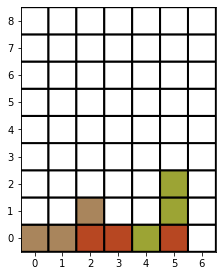

In [290]:
displayBoard(board)

In [291]:
all_move = findNotDuplicateMove(board)

In [292]:
all_move.shape

(18, 2, 2)

In [293]:
board = move(board, all_move[9])

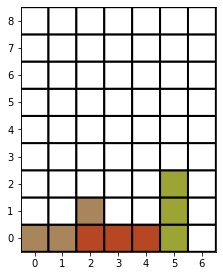

In [294]:
displayBoard(board)

In [295]:
board = remove(board)

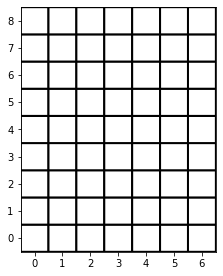

In [296]:
displayBoard(board)